In [1]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/Users/salil/Downloads/train-images-idx3-ubyte", "/Users/salil/Downloads/train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert("/Users/salil/Downloads/t10k-images-idx3-ubyte", "/Users/salil/Downloads/t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

In [2]:
import pandas as pd
pd.set_option('display.max_row', 10000)
pd.set_option('display.max_columns', 1000)

train = pd.read_csv("mnist_train.csv",header=None)
test = pd.read_csv("mnist_test.csv",header=None)
#print train.head(10)


0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: 0, dtype: int64


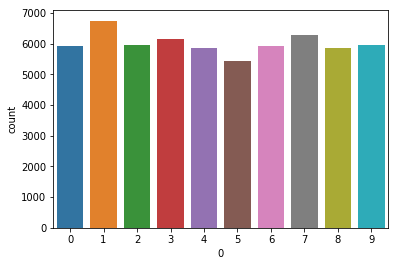

count       784
unique        1
top       False
freq        784
dtype: object
(60000, 784)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
#train = to_categorical(Y_train, num_classes = 10)
train_y = train[0]
print train_y.head(10)

# Drop 'label' column
train_x = train.drop(labels = [0],axis = 1) 
g = sns.countplot(train_y)

train_y.value_counts()
plt.show()

print train_x.isnull().any().describe()
print train_x.shape

Using TensorFlow backend.


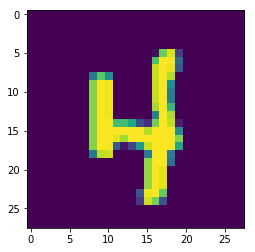

(54000, 28, 28, 1)


In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train_x = train_x.values.reshape(-1,28,28,1)
#test = test.values.reshape(-1,28,28,1)
train_x = train_x / 255.0
test = test / 255.0
train_y = to_categorical(train_y, num_classes = 10)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state=7)
g = plt.imshow(train_x[9][:,:,0])
plt.show()
print train_x.shape


In [9]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.5))


model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.5))

#model = Sequential()

#conv3_1 = Sequential()
#conv3_1.add(Dense(512,input_shape = (14,14,1), activation = 'relu'))
 
#conv3_2 = Sequential()
#conv3_2.add(Dense(512, input_shape =  (14,14,1), activation = 'relu'))
#model.add(Concatenate([conv3_1, conv3_2]))
#model.add(Dense(512, input_shape =  (7,7,1), activation = 'relu'))

model1.add(Flatten())
model1.add(Dense(1000, activation = "relu"))
model1.add(Dropout(0.2))
model1.add(Dense(500, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(10, activation = "softmax"))

model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

epochs = 1
batch_size = 64

datagen.fit(train_x)
history = model1.fit(train_x,train_y,
                              epochs=epochs, 
                              validation_data=(val_x,val_y),
                              verbose=1, 
                              steps_per_epoch=train_x.shape[0] // batch_size,
                              callbacks=[lr_reduction])


Epoch 1/1
